In [1]:
import os
import random
import pandas as pd
import numpy as np

import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
images_path = Path('images')
anno_path = Path('annotations')


def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]


def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [3]:
df_train = generate_train_df(anno_path)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,images\road0.png,267,400,trafficlight,98,62,208,232
1,images\road1.png,400,283,trafficlight,154,63,258,281
2,images\road10.png,400,267,trafficlight,106,3,244,263
3,images\road100.png,400,385,speedlimit,35,5,363,326
4,images\road101.png,400,200,speedlimit,195,7,392,194
...,...,...,...,...,...,...,...,...
872,images\road95.png,300,400,stop,90,101,268,257
873,images\road96.png,400,267,stop,209,58,326,179
874,images\road97.png,400,267,stop,42,66,130,154
875,images\road98.png,400,267,stop,138,17,376,245


In [4]:
df_train['class'].value_counts()

speedlimit      652
crosswalk        88
stop             76
trafficlight     61
Name: class, dtype: int64

In [5]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,images\road0.png,267,400,3,98,62,208,232
1,images\road1.png,400,283,3,154,63,258,281
2,images\road10.png,400,267,3,106,3,244,263
3,images\road100.png,400,385,0,35,5,363,326
4,images\road101.png,400,200,0,195,7,392,194


In [6]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)


def create_mask(bb, x):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y


def mask_to_bb(Y):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def create_bb_array(x):
    """Генерируем массив bounding box'a из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])


def resize_image_bb(read_path, write_path, bb, sz):
    """Ресайзим изображение и его bounding box и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [7]:
IM_SIZE = 300

In [8]:
new_paths = []
new_bbs = []
train_path_resized = Path('./images_resized')
Path.mkdir(train_path_resized, exist_ok=True)


for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,images\road0.png,267,400,3,98,62,208,232,images_resized\road0.png,"[46.0, 110.0, 173.0, 233.0]"
1,images\road1.png,400,283,3,154,63,258,281,images_resized\road1.png,"[66.0, 115.0, 297.0, 193.0]"
2,images\road10.png,400,267,3,106,3,244,263,images_resized\road10.png,"[3.0, 79.0, 295.0, 182.0]"
3,images\road100.png,400,385,0,35,5,363,326,images_resized\road100.png,"[4.0, 26.0, 253.0, 272.0]"
4,images\road101.png,400,200,0,195,7,392,194,images_resized\road101.png,"[10.0, 146.0, 291.0, 293.0]"


(293, 400, 3)


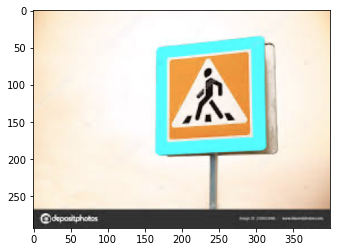

In [9]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

Y = create_mask(bb, im)
mask_to_bb(Y)

plt.imshow(im)


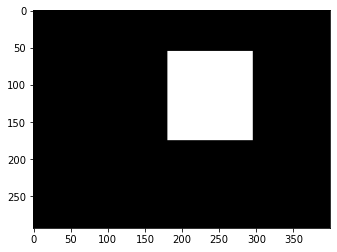

In [10]:
plt.imshow(Y, cmap='gray')

In [11]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix * c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    xx = crop(x, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    YY = crop(Y, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, is_transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

images_resized\road120.png


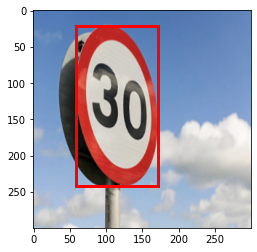

In [12]:
number = 25
im = cv2.imread(str(df_train['new_path'].values[number]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train['new_bb'].values[number])

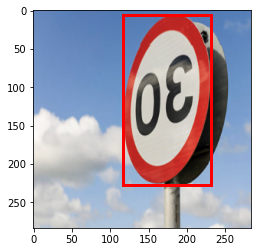

In [13]:
im, bb = transformsXY(str(df_train['new_path'].values[number]),
                      df_train['new_bb'].values[number],
                      is_transforms=True)
show_corner_bb(im, bb)

In [14]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]


class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, is_transforms=False):
        self.is_transforms = is_transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.is_transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

    
train_ds = RoadDataset(X_train['new_path'], X_train['new_bb'], y_train, is_transforms=True)
valid_ds = RoadDataset(X_val['new_path'], X_val['new_bb'], y_val)

In [15]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [16]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [17]:
resnet = models.resnet34(pretrained=True)
list(resnet.children())[:8]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [18]:
model = BB_model().cuda()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)
epochs = 2500
model

BB_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [19]:
def train():
    for i in range(epochs):
      
        model.train()
        total = 0
        sum_loss = 0

        for x, y_class, y_bb in train_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            
            # losses
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            
            loss = loss_class + loss_bb
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total += len_batch
            sum_loss += loss.item()
        
        train_loss = sum_loss / total

        # Eval
        model.eval()
        val_total = 0
        val_sum_loss = 0
        correct = 0

        for x, y_class, y_bb in valid_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
            
        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total
        if i%10==0:
          torch.save(model.state_dict(),'model.pth')
        print(f"Epoch [{i+1}/{epochs}]. train_loss {train_loss:.3f} val_loss {val_loss:.3f} val_acc {val_acc:.3f}")

In [20]:
train()

Epoch [1/2500]. train_loss 546.824 val_loss 502.627 val_acc 0.381


KeyboardInterrupt: 